Best epoch: 499
테스트 세트 정확도: 0.89


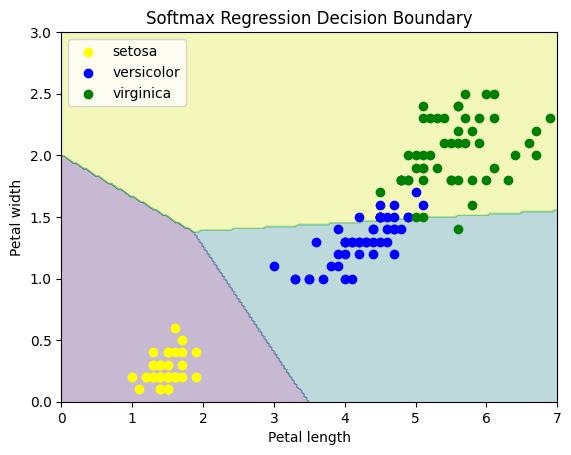

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. 데이터 준비
iris = load_iris()
X = iris.data[:, [2, 3]]  # petal length, petal width
y = iris.target

# Bias 추가
X = np.c_[np.ones((X.shape[0], 1)), X]

# 학습/검증/테스트 분할
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

# One-hot 인코딩
def to_one_hot(y, num_classes):
    ohe = np.zeros((len(y), num_classes))
    ohe[np.arange(len(y)), y] = 1
    return ohe

y_train_oh = to_one_hot(y_train, 3)
y_val_oh = to_one_hot(y_val, 3)

# 안정적인 softmax 구현
def softmax(logits):
    logits = logits - np.max(logits, axis=1, keepdims=True)  # 안정성
    exps = np.exp(logits)
    sums = np.sum(exps, axis=1, keepdims=True)
    return exps / sums

# cross-entropy
def cross_entropy(y_hat, y):
    eps = 1e-12
    y_hat = np.clip(y_hat, eps, 1-eps)
    return -np.mean(np.sum(y * np.log(y_hat), axis=1))

# 2. 학습 함수 (조기 종료 포함)
def fit(X_train, y_train_oh, X_val, y_val_oh, n_epochs=1000, lr=0.05, patience=15):
    m, n = X_train.shape
    k = y_train_oh.shape[1]
    rng = np.random.default_rng(42)
    theta = rng.normal(0, 0.1, size=(n, k))
    best_loss = np.inf
    best_theta = theta.copy()
    best_epoch = 0
    wait = 0

    for epoch in range(n_epochs):
        logits = X_train @ theta
        probs = softmax(logits)
        grad = (X_train.T @ (probs - y_train_oh)) / m
        theta -= lr * grad

        # 검증
        val_logits = X_val @ theta
        val_probs = softmax(val_logits)
        val_loss = cross_entropy(val_probs, y_val_oh)
        if val_loss < best_loss:
            best_loss = val_loss
            best_theta = theta.copy()
            best_epoch = epoch
            wait = 0
        else:
            wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    return best_theta, best_epoch, best_loss

# 3. 학습 진행
theta, best_epoch, best_loss = fit(X_train, y_train_oh, X_val, y_val_oh, n_epochs=500, lr=0.1, patience=15)
print("Best epoch:", best_epoch)

# 4. 테스트 정확도/예측
proba_test = softmax(X_test @ theta)
y_pred = np.argmax(proba_test, axis=1)
accuracy = np.mean(y_pred == y_test)
print(f"테스트 세트 정확도: {accuracy:.2f}")

# 5. 결정 경계 시각화
x0 = np.linspace(0, 7, 200)
x1 = np.linspace(0, 3, 200)
x0_grid, x1_grid = np.meshgrid(x0, x1)
X_grid = np.c_[np.ones(x0_grid.ravel().shape), x0_grid.ravel(), x1_grid.ravel()]
proba_grid = softmax(X_grid @ theta)
y_grid = np.argmax(proba_grid, axis=1).reshape(x0_grid.shape)

plt.contourf(x0_grid, x1_grid, y_grid, alpha=0.3)
plt.scatter(X[:,1][y==0], X[:,2][y==0], color='yellow', label='setosa')
plt.scatter(X[:,1][y==1], X[:,2][y==1], color='blue', label='versicolor')
plt.scatter(X[:,1][y==2], X[:,2][y==2], color='green', label='virginica')
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title("Softmax Regression Decision Boundary")
plt.legend()
plt.show()
